In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import warnings
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from create_dataframe import create_warming_df
from kmeans_functions import create_graph, silhouette_method, elbow_method

import seaborn as sns

# K Model++ with PCA dimension reduction Built using data downloaded from Kaggle with additional data scraped from Wikipedia

Shape of df: (224, 22)

Things to be careful of when building this model is there are a lot of null values replaced with '0'. This allows us to have a deeper dataset. It may be worth looking into pruning the data more. Certain columns that it might be worth dropping (values of 0):
- population: 37
- pop_density_km: 37
- land_area: 36
- total_area: 35

I found that dropping areas where the Population was 0 gave us the best results, leaving over only a few countries that still had most of the data points that we require

Shape after dropping pop: (187, 22)

In [5]:
df = create_warming_df()
df = df[df['population']!=0]
df.shape

(187, 22)

In [6]:
# Code pulled from 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

df2 = df[df.columns[6:-1]]

scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(df2), columns = df2.columns)
n_cluster = silhouette_method(data)

# Reduce the dimensions of the data down to two dimensions
reduced_data = PCA(n_components=2).fit_transform(data)

# Create a kmeans model through k-means ++ with n_clusters
kmeans = KMeans(init="k-means++", n_clusters=n_cluster, n_init=5)
kmeans.fit(reduced_data)

For n_clusters = 2 , the average silhouette_score is : 0.6384670132661437


KMeans(n_clusters=2, n_init=5)

([], [])

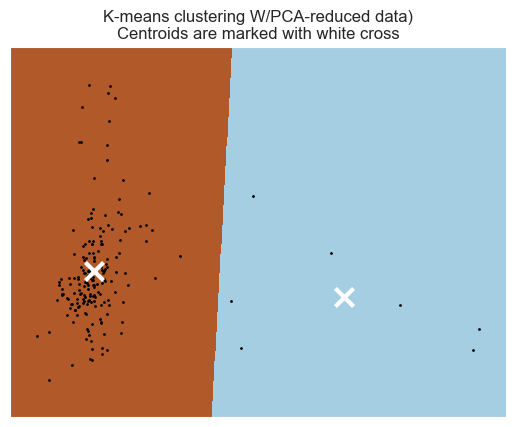

In [7]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering W/PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

In [9]:
df_results = create_warming_df()
df_results.insert(0, "kmeans_cluster", kmeans.labels_)
df_results[df_results['kmeans_cluster'] == 0]

,kmeans_cluster,name,ISO3,region,region_id,latitude,longitude,avg_indicator,coastline_km,coast_area_ratio,...,percent_water,eco_footprint,biocapacity,carbon_intensity_2018,population,pop_density_km,avg_elevation_km,max_elevation_km,min_elevation_km,annual_precipitation_avg_mm
8,0,australia,AUS,Oceania,3,-27.0,133.0,0.482098,66530.0,8.66,...,0.8,9.31,16.57,0.34,26821557,3.0,0.330,2.2280,-0.0150,534.0
22,0,brazil,BRA,Americas,4,-10.0,-55.0,0.537443,33379.0,3.99,...,0.6,3.11,9.08,0.16,203080756,25.0,0.320,2.9950,0.0000,1761.0
29,0,canada,CAN,Americas,4,60.0,-95.0,0.639951,265523.0,29.20,...,8.9,8.17,16.01,0.35,40769890,4.0,0.487,5.9590,0.0000,537.0
34,0,china,CHN,Asia,0,35.0,105.0,0.564459,30017.0,3.22,...,2.8,3.38,0.94,0.57,1409670000,149.0,1.840,0.0000,0.0000,645.0
72,0,india,IND,Asia,0,20.0,77.0,0.290639,17181.0,5.78,...,9.6,1.16,0.45,0.29,1392329000,435.0,0.160,8.5860,-0.0020,1083.0
137,0,russia,RUS,Europe,1,60.0,100.0,0.730115,110310.0,6.74,...,4.2,5.69,6.79,0.47,146203613,8.0,0.600,5.6420,-0.0280,460.0
178,0,united states,USA,Americas,4,38.0,-97.0,0.477918,133312.0,14.60,...,7.1,8.4,3.76,0.30,335893238,35.0,0.760,6.1905,-0.0855,715.0


Interestingly, when the data is condensed down to two dimensions we get the same result as before. This is really interesting because we have a silhouette score of 0.69, which is VERY high 

Look into dropping
- min elevetion
- Population
- Land area, total area, water area